In [3]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, models, datasets
from torchvision.models import resnet50, ResNet50_Weights
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, multilabel_confusion_matrix, roc_curve, auc
from sklearn.metrics import f1_score, accuracy_score, classification_report
import numpy as np
import os
from sklearn.metrics import precision_score, recall_score
import pandas as pd


In [4]:


########################################
# 1. Hyperparameters
########################################
BATCH_SIZE = 8
LR = 0.001
EPOCHS = 2
NUM_CLASSES = 20   # Pascal VOC has 20 classes

########################################
# 2. Transforms
########################################
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # resize for ResNet50
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]) # ImageNet normalization
])

########################################
# 3. Multi-label target encoding
########################################
VOC_CLASSES = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
    'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train',
    'tvmonitor'
]

def encode_voc_target(target):
    """Converts VOC annotation to multi-hot vector for 20 classes"""
    objects = target['annotation'].get('object', [])
    if not isinstance(objects, list):
        objects = [objects]  # single object case
    labels = [0] * NUM_CLASSES
    for obj in objects:
        if obj['name'] in VOC_CLASSES:
            idx = VOC_CLASSES.index(obj['name'])
            labels[idx] = 1
    return torch.tensor(labels, dtype=torch.float32)





########################################
# 4. Dataset & Dataloader
########################################
repo_root = "C:/Users/kamed/Desktop/argonne_K/object_detection_with_pascal_voc"
voc_root = os.path.join(repo_root, "VOCdevkit")  # parent of VOC2012

train_dataset = torchvision.datasets.VOCDetection(
    root=repo_root,
    year="2012",
    image_set="train",
    download=False,
    transform=transform,
    target_transform=encode_voc_target
)

val_dataset = torchvision.datasets.VOCDetection(
    root=repo_root,
    year="2012",
    image_set="val",
    download=False,
    transform=transform,
    target_transform=encode_voc_target
)
# Only use first 200 images for CPU testing
train_dataset = torch.utils.data.Subset(train_dataset, list(range(200)))
val_dataset = torch.utils.data.Subset(val_dataset, list(range(50)))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)

########################################
# 4b. Verify train/val split integrity
########################################

raw_train = torchvision.datasets.VOCDetection(
    root=repo_root,
    year="2012",
    image_set="train",
    download=False,
    transform=None,
    target_transform=None
)

raw_val = torchvision.datasets.VOCDetection(
    root=repo_root,
    year="2012",
    image_set="val",
    download=False,
    transform=None,
    target_transform=None
)
def get_image_ids(dataset):
    ids = []
    for idx in range(len(dataset)):
        # VOCDetection returns (img, target), where target has 'annotation'
        ann = dataset[idx][1]["annotation"]
        img_id = ann["filename"]
        ids.append(img_id)
    return set(ids)

train_ids = get_image_ids(raw_train)
val_ids = get_image_ids(raw_val)

# Intersection should be empty
overlap = train_ids.intersection(val_ids)
if len(overlap) > 0:
    print(f"WARNING ⚠️: {len(overlap)} images appear in both train and val sets!")
else:
    print("✅ No overlap between train and val splits.")

✅ No overlap between train and val splits.


In [5]:
########################################
# 5. Model (ResNet50 with transfer learning)
########################################

ResNetmodel = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
for param in ResNetmodel.parameters():
    param.requires_grad = False # freeze feature extractor

# Replace final layer for 20-class multi-label classification
ResNetmodel.fc = nn.Sequential(
    nn.Linear(ResNetmodel.fc.in_features, NUM_CLASSES),
    nn.Sigmoid()         # since multi-label, we need sigmoid not softmax
)

device = torch.device("cpu")  # force CPU
ResNetmodel = ResNetmodel.to(device)
print("model ready")
'''
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False   # freeze feature extractor

# Replace final layer for 20-class multi-label classification
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, NUM_CLASSES),
    nn.Sigmoid()   # since multi-label, we need sigmoid not softmax
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
'''

model ready


'\nmodel = models.resnet50(pretrained=True)\nfor param in model.parameters():\n    param.requires_grad = False   # freeze feature extractor\n\n# Replace final layer for 20-class multi-label classification\nmodel.fc = nn.Sequential(\n    nn.Linear(model.fc.in_features, NUM_CLASSES),\n    nn.Sigmoid()   # since multi-label, we need sigmoid not softmax\n)\n\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\nmodel = model.to(device)\n'

In [6]:
########################################
# 6. Loss & Optimizer
########################################
criterion = nn.BCELoss()  # binary cross entropy for multi-label
optimizer = optim.Adam(ResNetmodel.fc.parameters(), lr=LR)

########################################
# 6. Training Loop
########################################
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for images, targets in loader:
        images, targets = images.to(device), targets.float().to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

########################################
# 7. Validation / Metrics
########################################
from sklearn.metrics import f1_score, accuracy_score, classification_report, roc_curve, auc, multilabel_confusion_matrix

def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, targets in loader:
            images, targets = images.to(device), targets.float().to(device)
            outputs = model(images)
            y_true.append(targets.cpu().numpy())
            y_pred.append(outputs.cpu().numpy())

    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)

    # Threshold predictions at 0.5 for binary/multi-label classification
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Compute metrics
    roc_auc = roc_auc_score(y_true, y_pred, average="macro")
    f1_micro = f1_score(y_true, y_pred_binary, average="micro")
    f1_macro = f1_score(y_true, y_pred_binary, average="macro")
    acc = accuracy_score(y_true, y_pred_binary)
    cm = multilabel_confusion_matrix(y_true, y_pred_binary)
    report = classification_report(y_true, y_pred_binary, target_names=VOC_CLASSES, zero_division=0)

    return {
        "roc_auc": roc_auc,
        "confusion_matrices": cm,
        "f1_micro": f1_micro,
        "f1_macro": f1_macro,
        "accuracy": acc,
        "report": report,
        "y_true": y_true,
        "y_pred": y_pred
    }



In [7]:
########################################
# 8. Run Training
########################################
for epoch in range(EPOCHS):
    loss = train_one_epoch(ResNetmodel, train_loader, optimizer, criterion)
    metrics = evaluate(ResNetmodel, val_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {loss:.4f} - Val ROC AUC: {metrics['roc_auc']:.4f} - F1-micro: {metrics['f1_micro']:.4f} - F1-macro: {metrics['f1_macro']:.4f} - Accuracy: {metrics['accuracy']:.4f}")
    print(metrics["report"])

y_true = metrics["y_true"]
y_pred = metrics["y_pred"]


Epoch 1/2 - Loss: 0.2745 - Val ROC AUC: 0.5395 - F1-micro: 0.2430 - F1-macro: 0.0439 - Accuracy: 0.0200
              precision    recall  f1-score   support

   aeroplane       0.00      0.00      0.00         2
     bicycle       0.00      0.00      0.00         3
        bird       0.00      0.00      0.00         3
        boat       0.00      0.00      0.00         5
      bottle       0.00      0.00      0.00         3
         bus       0.00      0.00      0.00         2
         car       1.00      0.25      0.40         8
         cat       0.00      0.00      0.00         5
       chair       0.00      0.00      0.00         6
         cow       0.00      0.00      0.00         2
 diningtable       0.00      0.00      0.00         1
         dog       0.00      0.00      0.00         6
       horse       0.00      0.00      0.00         3
   motorbike       0.00      0.00      0.00         2
      person       0.35      0.73      0.48        15
 pottedplant       0.00      0.

C:\Users\kamed\AppData\Local\Temp\ipykernel_20792\1903778966.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", NUM_CLASSES)


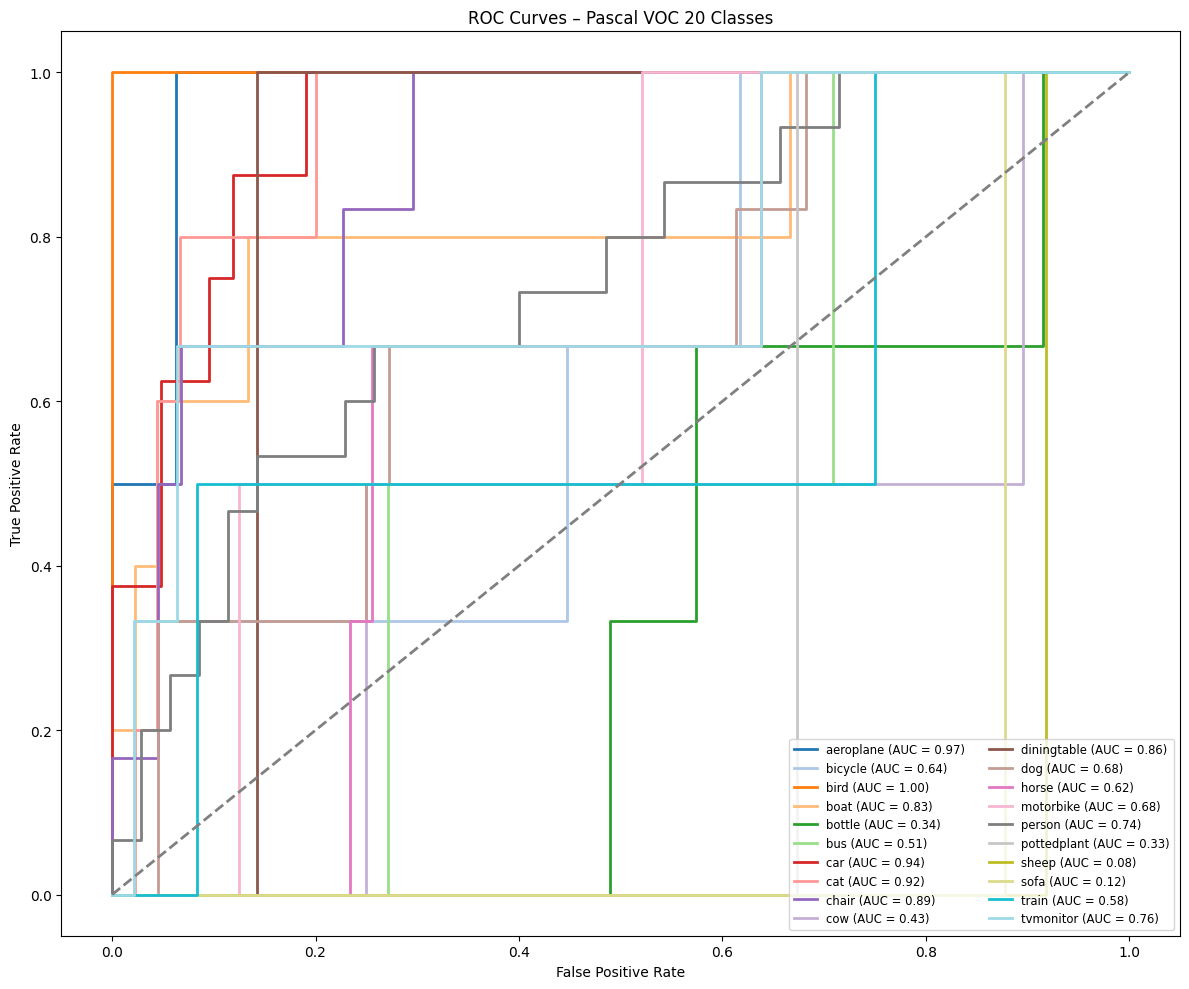

In [9]:
########################################
# 9. Plot ROC Curve for ALL 20 classes
########################################
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
colors = plt.cm.get_cmap("tab20", NUM_CLASSES)

for cls_idx, cls_name in enumerate(VOC_CLASSES):
    fpr, tpr, _ = roc_curve(y_true[:, cls_idx], y_pred[:, cls_idx])
    roc_auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors(cls_idx), lw=2,
             label=f"{cls_name} (AUC = {roc_auc_val:.2f})")

plt.plot([0, 1], [0, 1], "--", color="gray", lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – Pascal VOC 20 Classes")
plt.legend(loc="lower right", fontsize="small", ncol=2)
plt.tight_layout()
plt.show()

In [1]:
########################################
# 10. Precision & Recall per class
########################################
from sklearn.metrics import precision_score, recall_score
import pandas as pd

# Binary predictions at 0.5 threshold
y_pred_binary = (y_pred > 0.5).astype(int)

# Per-class precision & recall
precision_per_class = precision_score(y_true, y_pred_binary, average=None, zero_division=0)
recall_per_class = recall_score(y_true, y_pred_binary, average=None, zero_division=0)

# Build DataFrame
df_cls_metrics = pd.DataFrame({
    "class": VOC_CLASSES,
    "Precision": precision_per_class,
    "Recall": recall_per_class
})

# Add macro/micro averages
df_cls_metrics.loc[len(df_cls_metrics)] = [
    "Macro Avg",
    precision_score(y_true, y_pred_binary, average="macro", zero_division=0),
    recall_score(y_true, y_pred_binary, average="macro", zero_division=0)
]
df_cls_metrics.loc[len(df_cls_metrics)] = [
    "Micro Avg",
    precision_score(y_true, y_pred_binary, average="micro", zero_division=0),
    recall_score(y_true, y_pred_binary, average="micro", zero_division=0)
]

print("\nPer-class Precision/Recall:\n", df_cls_metrics)

# Save to CSV
df_cls_metrics.to_csv(os.path.join(repo_root, "resnet_val_precision_recall.csv"), index=False)


########################################
# 11. Bar charts for Precision & Recall
########################################
import matplotlib.pyplot as plt

# Precision bar chart
plt.figure(figsize=(12, 6))
plt.bar(df_cls_metrics["class"][:-2], df_cls_metrics["Precision"][:-2])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Precision")
plt.title("ResNet Per-Class Precision (Pascal VOC)")
plt.tight_layout()
plt.savefig(os.path.join(repo_root, "resnet_perclass_precision.png"), bbox_inches="tight")
plt.close()

# Recall bar chart
plt.figure(figsize=(12, 6))
plt.bar(df_cls_metrics["class"][:-2], df_cls_metrics["Recall"][:-2])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Recall")
plt.title("ResNet Per-Class Recall (Pascal VOC)")
plt.tight_layout()
plt.savefig(os.path.join(repo_root, "resnet_perclass_recall.png"), bbox_inches="tight")
plt.close()

print("Saved per-class Precision and Recall charts for ResNet model.")


NameError: name 'y_pred' is not defined

In [10]:
########################################
# 10. Precision & Recall per class
########################################


# Binary predictions at 0.5 threshold
y_pred_binary = (y_pred > 0.5).astype(int)

# Per-class precision & recall
precision_per_class = precision_score(y_true, y_pred_binary, average=None, zero_division=0)
recall_per_class = recall_score(y_true, y_pred_binary, average=None, zero_division=0)

# Build DataFrame
df_cls_metrics = pd.DataFrame({
    "class": VOC_CLASSES,
    "Precision": precision_per_class,
    "Recall": recall_per_class
})

# Add macro/micro averages
df_cls_metrics.loc[len(df_cls_metrics)] = [
    "Macro Avg",
    precision_score(y_true, y_pred_binary, average="macro", zero_division=0),
    recall_score(y_true, y_pred_binary, average="macro", zero_division=0)
]
df_cls_metrics.loc[len(df_cls_metrics)] = [
    "Micro Avg",
    precision_score(y_true, y_pred_binary, average="micro", zero_division=0),
    recall_score(y_true, y_pred_binary, average="micro", zero_division=0)
]

print("\nPer-class Precision/Recall:\n", df_cls_metrics)

# Save to CSV
df_cls_metrics.to_csv(os.path.join(repo_root, "resnet_val_precision_recall.csv"), index=False)


########################################
# 11. Bar charts for Precision & Recall
########################################
import matplotlib.pyplot as plt

# Precision bar chart
plt.figure(figsize=(12, 6))
plt.bar(df_cls_metrics["class"][:-2], df_cls_metrics["Precision"][:-2])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Precision")
plt.title("ResNet Per-Class Precision (Pascal VOC)")
plt.tight_layout()
plt.savefig(os.path.join(repo_root, "resnet_perclass_precision.png"), bbox_inches="tight")
plt.close()

# Recall bar chart
plt.figure(figsize=(12, 6))
plt.bar(df_cls_metrics["class"][:-2], df_cls_metrics["Recall"][:-2])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Recall")
plt.title("ResNet Per-Class Recall (Pascal VOC)")
plt.tight_layout()
plt.savefig(os.path.join(repo_root, "resnet_perclass_recall.png"), bbox_inches="tight")
plt.close()

print("Saved per-class Precision and Recall charts for ResNet model.")



Per-class Precision/Recall:
           class  Precision    Recall
0     aeroplane       0.00  0.000000
1       bicycle       0.00  0.000000
2          bird       0.00  0.000000
3          boat       0.00  0.000000
4        bottle       0.00  0.000000
5           bus       0.00  0.000000
6           car       0.00  0.000000
7           cat       0.00  0.000000
8         chair       0.00  0.000000
9           cow       0.00  0.000000
10  diningtable       0.00  0.000000
11          dog       0.00  0.000000
12        horse       0.00  0.000000
13    motorbike       0.00  0.000000
14       person       0.40  0.800000
15  pottedplant       0.00  0.000000
16        sheep       0.00  0.000000
17         sofa       0.00  0.000000
18        train       0.00  0.000000
19    tvmonitor       0.00  0.000000
20    Macro Avg       0.02  0.040000
21    Micro Avg       0.40  0.162162
Saved per-class Precision and Recall charts for ResNet model.
